# Reprojecting to other coordinate system:

## Setting up:

In [1]:
# run script that installs missing libraries
#! chmod 755 ../scripts.sh
#! ../scripts.sh

### Imports

In [2]:
import os
import sys
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join

sys.path.append('../')
from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Google cloud info
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Read data

### GCM lat-lon:

In [4]:
# Connect to Google Cloud Storage
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Read catalogue
df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip5.csv")

# Create dataframe from function:
dg = createGCM_Pangeo(df,fs)
dg

Experiments:
---------------------
['1pctCO2' 'abrupt-4xCO2' 'rcp85' 'historical' 'piControl']
Member ids:
---------------------
['r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1']


<xarray.Dataset>
Dimensions:    (lat: 145, bnds: 2, lon: 192, time: 3012)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.38 -89.38 ... 89.38 89.38 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon_bnds   (lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 357.2 359.1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1872, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    psl        (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    uas        (time, lat, lon) float32 dask.array<chunksize=(451, 145, 192), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    rlut       (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    rsdt       (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    vas        (time, lat, lon) float32 dask.array<chunksize=(451, 145, 192), meta=np.ndarray>
    rsut       (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
Attributes: (12/28)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    references:             See http://wiki.csiro.au/confluence/display/ACCES...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413

#### Define antarctica region

Max and min values of lat: -90.00° -> -40.00° and lon: 0.00° -> 358.12°


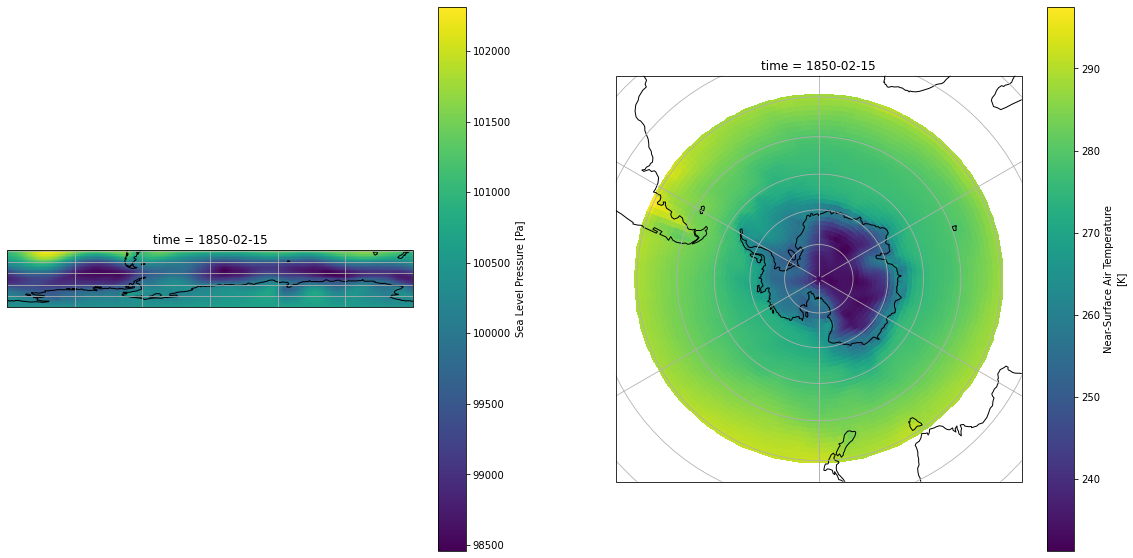

In [5]:
# define antarctica as 90° S to 60° S in latitude and full longitude
#nlimit=-60

nlimit = -40
lat = dg.lat.sel(lat=slice(-90,nlimit))
lon = dg.lon

antarctica = dg.sel(lat=slice(-90,nlimit))

# Define GCM
GCM = antarctica.sortby(['lat', 'lon', 'time'])
printMaxMin_LatLon(GCM.lat, GCM.lon, unit='°')

# Plot in both projections
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.PlateCarree(central_longitude=0)
ax = plt.subplot(1, 2, 1, projection=map_proj)
antarctica.psl.isel(time=1).plot(ax=ax, x='lon', y='lat',
                          transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 2, 2, projection=map_proj)
GCM.tas.isel(time=1).plot(ax=ax, x='lon', y='lat',
                          transform=ccrs.PlateCarree())  # data
ax.coastlines()
ax.gridlines()

### RCM x-y:

In [6]:
# open from google cloud
VAR = 'CC'
(pathGC, fileGC) = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
RCM_xy = BasicPreprocRCM(ProcessRCMVar(VAR, xr.open_dataset(fileGC)))

os.remove(fileGC)
dates = pd.DatetimeIndex(RCM_xy.time.values)
print ('Unique years in the dataset:', dates.year.unique().values)

printMaxMin_XY(RCM_xy.x, RCM_xy.y, unit='m')

RCM_xy

Unique years in the dataset: [1980]
Max and min values of x: -3010000.00m -> 3115000.00m and y: -2555000.00m -> 2590000.00m


<xarray.Dataset>
Dimensions:      (time: 366, y: 148, x: 176)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-12-31T12:...
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Data variables:
    CC           (time, y, x) float32 ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 12:02:39 2022: ncap2 -O -s CC=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

## Transform GCM lat/lon -> x/y:

Want to downsample RCM grid so that it goes from resolution of 35km to 150km

### Create downsampled RCM grid:
To change GCM resolution from degrees to km use formula:

x = deg_lon * distance between lon lines at point

y = deg_lat * distance between lat lines at point

Take d(lon) at -60°lat is 55km and d(lat) at -60°lat is 110km ([Link](https://stevemorse.org/nearest/distance.php))

Then x = 68km and y = 206km

In [7]:
# Create downsampled RCM grid on which we'll interpolate GCM
resx = 90
resy = 32
grid = True
gridx, gridy = create_downs_RCMgrid(grid=grid, resx = resx, resy = resy)

Original RCM grid:
----------------------
Max and min values of x: -3010.00km -> 3115.00km and y: -2555.00km -> 2590.00km
shape: (148, 176)
resolution: (35.0, 35.0)
bounds: (-3027.5, 2607.5, 3132.5, -2572.5)
CRS: EPSG:3031

Downsample to new resolution:
----------------------
Max and min values of x: -5848.00km -> 6052.00km and y: -15038.00km -> 15244.00km
shape: (148, 176)
resolution: (68.0, 205.99998671343536)
bounds: (-5882.0, 15346.999016794218, 6086.0, -15140.999016794218)
CRS: EPSG:3031

Cut so that on original x,y bounds:
--------------------------
Max and min values of x: -2992.00km -> 3060.00km and y: -3296.00km -> 3296.00km
New grid shape (gridx, gridy): (90,) (33,)


### Interpolate GCM on downsampled RCM grid:

In [8]:
print('\n---------------------------------\nRight part:\n---------------------------------\n')
GCM_xy_right = InterpolateGCM(GCM, RCM_xy, gridx, gridy, left = False)
print('\n---------------------------------\nLeft part:\n---------------------------------\n')
GCM_xy_left = InterpolateGCM(GCM, RCM_xy, gridx, gridy, left = True)

# Assemble two parts:
GCM_xy = GCM_xy_right.merge(GCM_xy_left)


---------------------------------
Right part:
---------------------------------

Shape of GCM data: time: 3012, lat: 41, lon: 192
-----------------
Shape of RCM data: time: 366, y: 148, x: 176
-----------------
Mesh shapes: (33, 90), (33, 90)
Lat-lon mesh:
-----------------
Max and min values of lat: -90.00° -> -50.22° and lon: -178.82° -> 180.00°

Interpolate:

GCM before interpolation:
-----------------
Max and min values of lat: -90.00° -> -40.00° and lon: 0.00° -> 358.12°

GCM after interpolation
-----------------
Max and min values of lat: -90.00° -> -50.22° and lon: -178.82° -> 180.00°

Replace coordinates by new coordinates:

---------------------------------
Left part:
---------------------------------

After transf
Max and min values of lat: -90.00° -> -40.00° and lon: -180.00° -> 178.12°
Shape of GCM data: time: 3012, lat: 41, lon: 192
-----------------
Shape of RCM data: time: 366, y: 148, x: 176
-----------------
Mesh shapes: (33, 90), (33, 90)
Lat-lon mesh:
--------------

In [9]:
GCM_xy

<xarray.Dataset>
Dimensions:      (y: 33, x: 90, bnds: 2, time: 3012)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -3.296e+06 -3.09e+06 ... 3.09e+06 3.296e+06
Dimensions without coordinates: bnds
Data variables:
    lat_bnds     (y, x, bnds) float64 -50.62 -49.38 -51.88 ... -50.62 -49.38
    lon_bnds     (y, x, bnds) float64 222.2 224.1 220.3 ... 44.06 42.19 44.06
    psl          (time, y, x) float32 1.009e+05 1.007e+05 ... 9.955e+04
    time_bnds    (time, bnds) datetime64[ns] 1850-01-01 ... 2101-01-01
    uas          (time, y, x) float32 7.417 7.574 7.574 ... 6.803 7.343 7.343
    pr           (time, y, x) float32 4.041e-05 4.014e-05 ... 3.536e-05
    rlut         (time, y, x) float32 234.6 230.8 230.8 ... 216.1 218.0 218.0
    tas          (time, y, x) float32 284.7 284.1 284.1 ... 278.9 279.7 279.7
    rsdt         (time, y, x) float32 488.9 487.1 487.1 ... 510.8 511.6 511.6
    vas          (time, y, x) float32 -1.297 -0.8773 -0.8773 ... -1.764 -1.764
    rsut         (time, y, x) float32 146.8 154.2 154.2 ... 176.0 174.3 174.3
    spatial_ref  int64 0
Attributes: (12/29)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413
    crs:                    epsg:4326

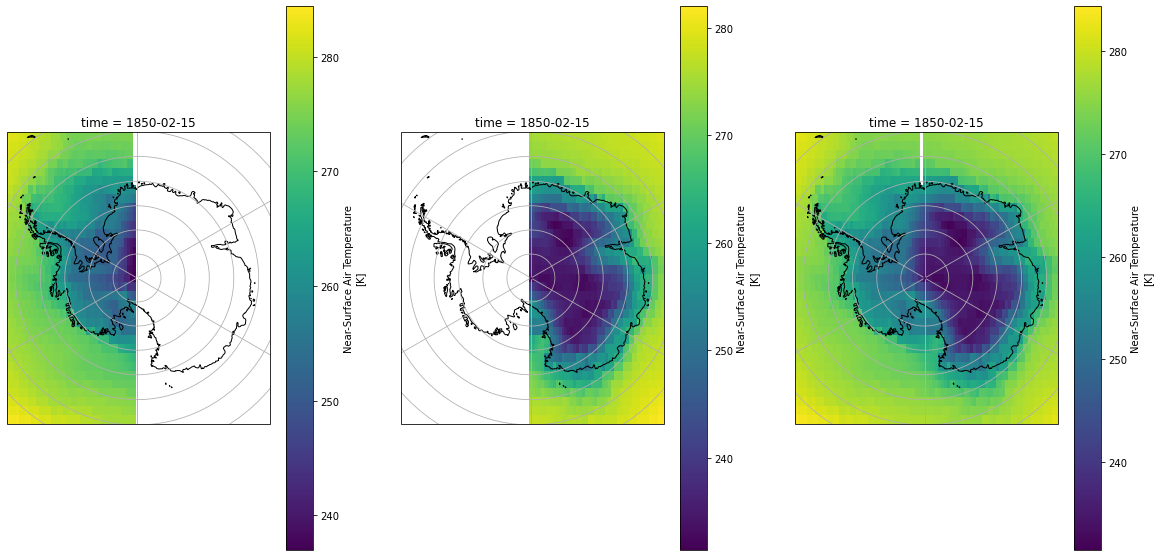

In [10]:
f = plt.figure(figsize=(20, 10))

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax =plt.subplot(1,3,2,projection=map_proj)
GCM_xy_right.tas.isel(time = 1).plot(ax=ax, x='x', y='y', 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax =plt.subplot(1,3,1,projection=map_proj)
GCM_xy_left.tas.isel(time = 1).plot(ax=ax, x='x', y='y', 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax =plt.subplot(1,3,3,projection=map_proj)
GCM_xy.tas.isel(time = 1).plot(ax=ax, x='x', y='y', 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

### Save new projection to GC

In [13]:
# Save file
if grid:
    name = f'ACCESS1-3-stereographic_monthly_{resx}x{resy}.nc'
else:
    name = 'ACCESS1-3-stereographic_monthly.nc'

# save file locally:
GCM_xy.attrs['crs'] = 3031
GCM_xy.to_netcdf(name)

# upload to GC:
print(f'Uploading {name} to GC....')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
uploadFileToGC(pathGC, name)
os.remove(name)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


Uploading ACCESS1-3-stereographic_monthly_90x32.nc to GC....
